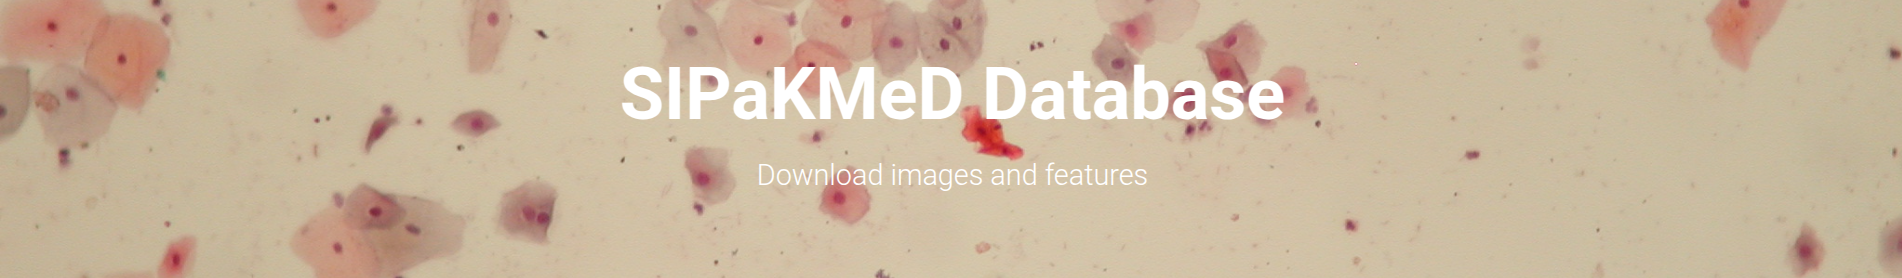

The SIPaKMeD database is publicly available and it can be used for experimental purposes with the request to cite the following paper:

**Marina E. Plissiti, Panagiotis Dimitrakopoulos, Giorgos Sfikas, Christophoros Nikou, Olga Krikoni, Antonia Charchanti, SIPAKMED: A new dataset for feature and image based classification of normal and pathological cervical cells in Pap smear images, IEEE International Conference on Image Processing (ICIP) 2018, Athens, Greece, 7-10 October 2018.**

In [34]:
import os, sys
import pandas as pd
import numpy as np
import torch
import torchvision.models as models
import torchvision.transforms as transforms
from sklearn.preprocessing import StandardScaler
sys.path.append(os.path.abspath('..'))


from Preprocessing.preprocessing import split_data
from tqdm import tqdm

**01. Load & Explore the Data**

In [16]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import cv2
import numpy as np

DATASET_PATH = "../Datasets/SIPaKMeD"
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
OUTPUT_FEATURES_PATH = "../Feature_Extraction"

def load_dataset(dataset_path):
    """
    Loads the dataset by scanning directories for `.bmp` images.
    Returns:
    - file_paths: Dict with class names as keys and list of image paths as values
    - class_counts: Dict with class names as keys and count of images as values
    """
    file_paths = {}
    class_counts = {}

    for class_name in sorted(os.listdir(dataset_path)):  
        class_dir = os.path.join(dataset_path, class_name, "CROPPED")
        if os.path.isdir(class_dir):
            bmp_files = [os.path.join(class_dir, f) for f in os.listdir(class_dir) if f.endswith(".bmp")]
            file_paths[class_name] = bmp_files
            class_counts[class_name] = len(bmp_files)

    return file_paths, class_counts

def visualize_class_distribution(class_counts):
    """
    Plots a bar chart showing class distribution.
    """
    plt.figure(figsize=(8, 6))
    sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")
    plt.title("Class Distribution in SIPaKMeD Dataset")
    plt.xlabel("Class")
    plt.ylabel("Number of Images")
    plt.xticks(rotation=20)
    plt.show()
    
    

def plot_sample_images(file_paths, num_samples=5):
    """
    Plots sample images from each class.
    """
    fig, axes = plt.subplots(len(file_paths), num_samples, figsize=(num_samples * 2, len(file_paths) * 2))

    for i, (class_name, paths) in enumerate(file_paths.items()):
        sample_paths = np.random.choice(paths, num_samples, replace=False) if len(paths) >= num_samples else paths
        for j, img_path in enumerate(sample_paths):
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            axes[i, j].imshow(img)
            axes[i, j].axis("off")
            if j == 0:
                axes[i, j].set_title(class_name, fontsize=12, fontweight="bold")
    
    plt.tight_layout()
    plt.show()


Class Counts: {'im_Dyskeratotic': 813, 'im_Koilocytotic': 825, 'im_Metaplastic': 793, 'im_Parabasal': 787, 'im_Superficial-Intermediate': 831}


/tmp/ipykernel_9052/3771611738.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()), palette="viridis")


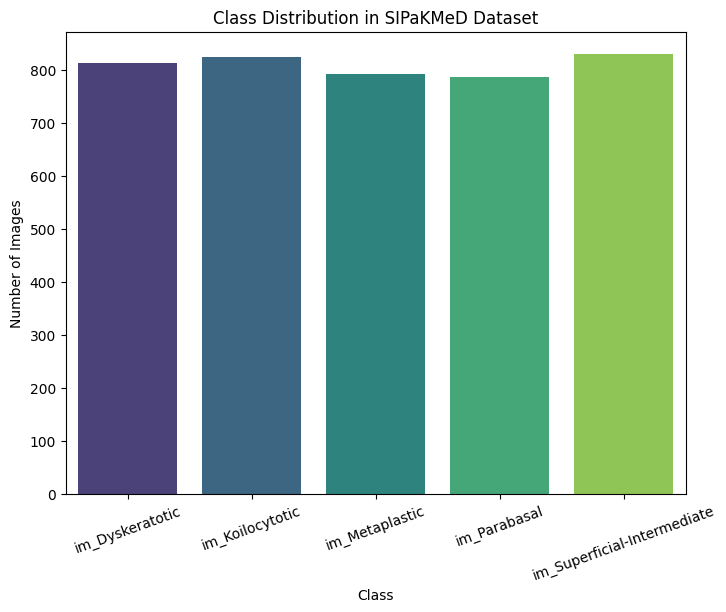

In [17]:
file_paths, class_counts = load_dataset(DATASET_PATH)
print(f"Class Counts: {class_counts}")
visualize_class_distribution(class_counts)


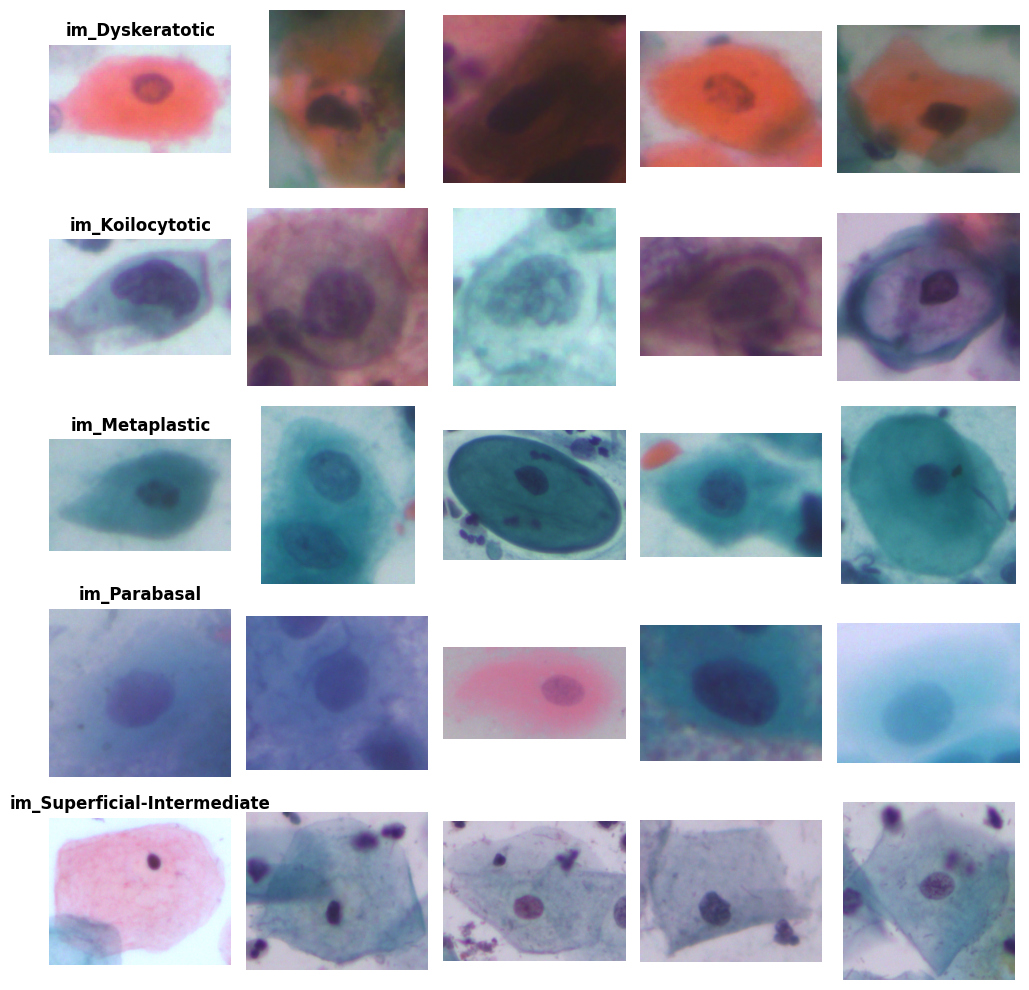

In [18]:
plot_sample_images(file_paths, num_samples=5)

**02. Data Preprocessing.**

* split data

In [21]:
!python ../Datasets/split.py

Class: im_Dyskeratotic → Total images: 813
Class: im_Parabasal → Total images: 787
Class: im_Superficial-Intermediate → Total images: 831
Class: im_Koilocytotic → Total images: 825
Class: im_Metaplastic → Total images: 793
Dataset split into train, cal, val, and test sets successfully.
Total images processed: 4049
Data split successfully into train, cal, val, and test sets.


**03. Feature Extraction**

* 3.1 Models for extraction

* `ResNet5`
* `VGG_Lite`
* `InceptionV3`
* `EfficientNetB7`

In [24]:
!python ../Preprocessing/extractors.py


[INFO] Running feature extraction using 4 parallel processes...

[INFO] Starting feature extraction: ResNet50 | train

[INFO] Starting feature extraction: ResNet50 | cal

[INFO] Starting feature extraction: ResNet50 | val

[INFO] Starting feature extraction: ResNet50 | test
/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115370/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after progra

**04. Feature visualization (PCA/t-SNE)**


- How separable the features are across classes.

- The effectiveness of ResNet50 vs. DenseNet121 in feature extraction.

- How well the extracted features preserve class structure.

In [25]:
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler

FEATURES_PATH = "../Feature_Extraction"

def load_extracted_features(model_name, split_name='train'):
    feature_path = os.path.join(FEATURES_PATH, f"{model_name}_{split_name}_features.npy")
    label_path = os.path.join(FEATURES_PATH, f"{split_name}_labels.npy")
    
    X = np.load(feature_path)
    if len(X.shape) > 2:
        X = X.reshape(X.shape[0], -1)
    y = np.load(label_path)
    
    scaler = StandardScaler()
    X = scaler.fit_transform(X)
    return X, y

import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

FEATURES_PATH = "../Feature_Extraction"

def visualize_tsne(models=["ResNet50", "DenseNet121"], split="train", perplexity=30, n_iter=1000, n_pca=50):
    """
    Generates side-by-side t-SNE visualizations for different models with class colors.

    Parameters:
    - models: List of model names whose features to visualize.
    - split: Dataset split to visualize (default is "train").
    - perplexity: t-SNE perplexity parameter (default=30).
    - n_iter: Number of t-SNE iterations (default=1000).
    - n_pca: Number of PCA components before applying t-SNE (default=50).

    The function automatically loads features, applies PCA, then t-SNE, and plots results.
    """
    fig, axes = plt.subplots(1, len(models), figsize=(7 * len(models), 6))

    if len(models) == 1:
        axes = [axes]

    label_path = os.path.join(FEATURES_PATH, f"{split}_labels.npy")
    if not os.path.exists(label_path):
        raise FileNotFoundError(f"Labels file not found: {label_path}")
    y_labels = np.load(label_path)
    
    # Define color palette for classes
    num_classes = len(np.unique(y_labels))
    palette = sns.color_palette("husl", num_classes)

    for i, model_name in enumerate(models):
        feature_path = os.path.join(FEATURES_PATH, f"{model_name}_{split}_features.npy")
        
        if not os.path.exists(feature_path):
            print(f"Skipping {model_name}: Feature file not found: {feature_path}")
            continue
        
        X_features = np.load(feature_path)

        if len(X_features.shape) > 2:
            X_features = X_features.reshape(X_features.shape[0], -1)

        pca = PCA(n_components=n_pca)
        X_pca = pca.fit_transform(X_features)

        tsne = TSNE(n_components=2, perplexity=perplexity, n_iter=n_iter, random_state=42)
        X_tsne = tsne.fit_transform(X_pca)

        sns.scatterplot(x=X_tsne[:, 0], y=X_tsne[:, 1], hue=y_labels, palette=palette, alpha=0.7, ax=axes[i])
        axes[i].set_title(f"t-SNE Visualization - {model_name}")
        axes[i].set_xlabel("t-SNE Component 1")
        axes[i].set_ylabel("t-SNE Component 2")

    plt.legend(title="Classes", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()



/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(
/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:1162: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


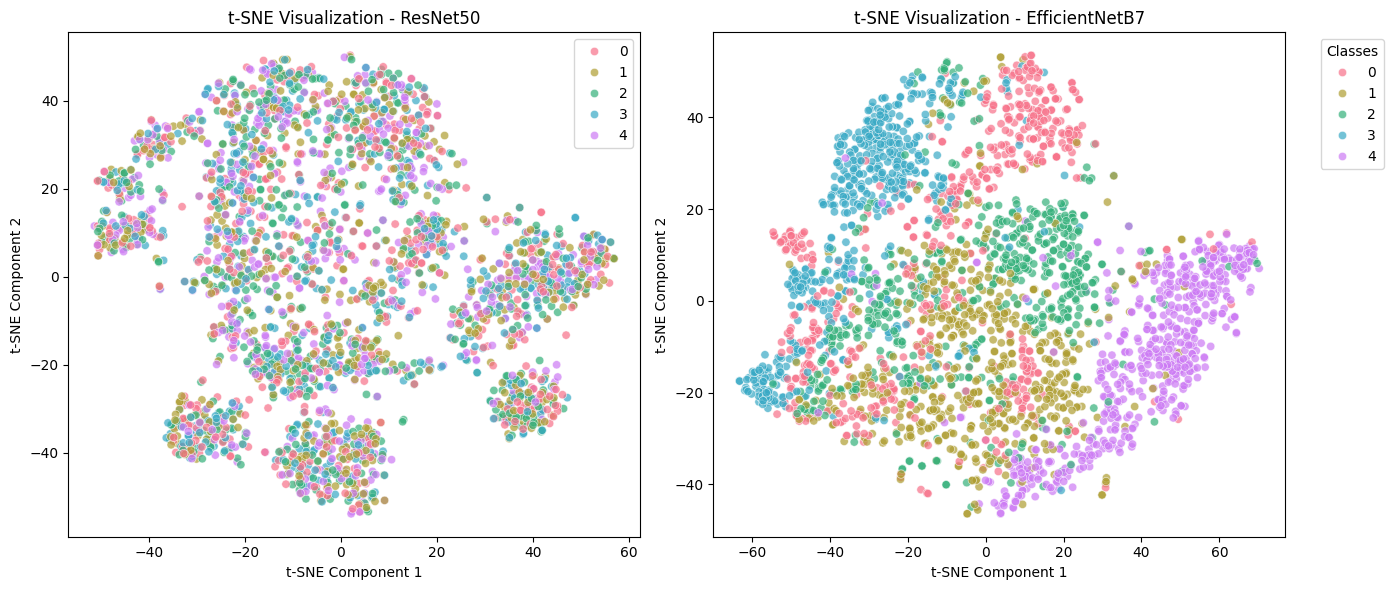

In [26]:
visualize_tsne(models=["ResNet50", "EfficientNetB7"])



In [12]:
feature_extractor_name = "ResNet50"
X_train, y_train = load_extracted_features(feature_extractor_name, split_name="train")
X_cal, y_cal = load_extracted_features(feature_extractor_name, split_name="cal")
X_val, y_val = load_extracted_features(feature_extractor_name, split_name="val")
X_test, y_test = load_extracted_features(feature_extractor_name, split_name="test")

In [ ]:
import matplotlib.pyplot as plt
import json


def load_metrics(model_name):
    """
    Loads training metrics from saved JSON file.
    """
    
    metrics_path = f"../Outputs/models/{model_name}_metrics.json"
    
    with open(metrics_path, "r") as f:
        metrics = json.load(f)
    
    return metrics



def plot_metrics(metrics, model_name="Model"):
    """
    Plots training and validation loss and accuracy over epochs.
    """
    epochs = range(1, len(metrics["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, metrics["train_loss"], label="Train Loss")
    plt.plot(epochs, metrics["val_loss"], label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} - Loss Over Epochs")
    plt.legend()

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, metrics["train_accuracy"], label="Train Accuracy")
    plt.plot(epochs, metrics["val_accuracy"], label="Validation Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title(f"{model_name} - Accuracy Over Epochs")
    plt.legend()

    plt.show()



**05. Train the Models**

`5.1 Single Determinist Network`

**A. Standard Network without Uncertainty** 

In [ ]:
!python ../Uncertainty_Quantification/Single_Network/main.py --train --epochs 25 --batch_size 32  --extractor_name EfficientNetB7
model_name = "EfficientNetB7"


📌 Project root added to PYTHONPATH: /home/conite/Documents/STAGE/HybridUncertaintyAwareDL
/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115370/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Training Model (Uncertainty: False)

Epoch 1/25
----------------------------------------
Training Progress: 100%|████████████████████████| 45/45 [00:00<00:00, 54.66it/s]
Train Loss: 1.5513 | Train Accuracy: 0.5544
Validation Loss: 1.3646 | Validation Accuracy: 0.6303

Epoch 2/25
----------------------------------------
Training Progress: 100%|████████████████████████| 45/45 [00:00<00:00, 60.63it/s]
Train Loss: 1.2463 | Train Accuracy: 0.7115
V

In [38]:
model_name = "EfficientNetB7"
metrics = load_metrics(model_name)
plot_metrics(metrics, model_name)

FileNotFoundError: [Errno 2] No such file or directory: '../Outputs/models/EfficientNetB7_metrics.json'

**B. Uncertainty using Expected Mean Square Error (MSE)**

formula

In [40]:
!python ../Uncertainty_Quantification/Single_Network/main.py --train --epochs 25 --batch_size 32 --uncertainty --mse --extractor_name EfficientNetB7
model_name = "EfficientNetB7"

📌 Project root added to PYTHONPATH: /home/conite/Documents/STAGE/HybridUncertaintyAwareDL
/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/torch/cuda/__init__.py:128: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at /opt/conda/conda-bld/pytorch_1724789115370/work/c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0
Training Model (Uncertainty: True)

Epoch 1/25
----------------------------------------
Training Progress:   0%|                                 | 0/89 [00:00<?, ?it/s][DEBUG] Batch size: 32
[DEBUG] Model Output Shape: torch.Size([32, 5])
[DEBUG] One-hot Labels Shape: torch.Size([32, 5])
[DEBUG] Alpha shape: torch.Size([32, 5])
[DEBUG] One-hot Labels (y) shape: torch.Size([32, 5])
[DEBUG] Batch size: 32
[DEBUG] Model Output Shape: torch.Size([

**C. Uncertainty using Expected Cross Entropy (Log Loss)**

formula

In [ ]:
!python Single_Network/main.py --train --epochs 25 --batch_size 64 --uncertainty --log --extractor_name EfficientNetB7

✔ Encourages the network to distinguish ID vs. OOD confidently.
I need to create OOD sample for testing

**D. Uncertainty using Negative Log of the Expected Likelihood (Digamma Loss)**

**5.2 Train Deep Ensemble**

Approach 1: Different Models with Different Structures

In [102]:
from sklearn.ensemble import RandomForestClassifier
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from sklearn.svm import SVC

def build_mlp(input_shape):
    model = Sequential([
        Dense(512, activation="relu", input_shape=input_shape),
        Dropout(0.5),
        Dense(256, activation="relu"),
        Dropout(0.5),
        Dense(5, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def build_cnn(input_shape):
    model = Sequential([
        Flatten(input_shape=input_shape),
        Dense(512, activation="relu"),
        Dense(5, activation="softmax")
    ])
    model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


def train_deep_ensemble_DS(models, X_train, y_train, epochs=20):
    """Trains a Deep Ensemble model with different architectures."""
    
    print("\nTraining Deep Ensemble (Different Structures)...")

    if len(X_train.shape) == 1:
        X_train = np.expand_dims(X_train, axis=-1) 
    
    ensemble_models = []
    for i, model in enumerate(models):
        print(f"\nTraining Model {i+1}/{len(models)}... ({type(model).__name__})")

        if isinstance(model, (tf.keras.Model)): 
            expected_shape = model.input_shape[1:]  
            if X_train.shape[1:] != expected_shape:
                raise ValueError(f"Shape mismatch: Model expects {expected_shape}, but got {X_train.shape[1:]}")

            model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)
        else: 
            model.fit(X_train, y_train)

        ensemble_models.append(model)
    
    return ensemble_models

svm_model = SVC(kernel="linear", probability=True)  
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
mlp_model = build_mlp(input_shape=(X_train.shape[1],)) 
cnn_model = build_cnn(input_shape=(X_train.shape[1],))

# Train Deep Ensemble
ensemble_models_DS = train_deep_ensemble_DS([svm_model, rf_model, mlp_model, cnn_model], X_train, y_train, epochs=20)


/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)



Training Deep Ensemble (Different Structures)...

Training Model 1/4... (SVC)

Training Model 2/4... (RandomForestClassifier)

Training Model 3/4... (Sequential)
Epoch 1/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.5979 - loss: 1.1266
Epoch 2/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.7868 - loss: 0.6073
Epoch 3/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8148 - loss: 0.5116
Epoch 4/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.8474 - loss: 0.4482
Epoch 5/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.8696 - loss: 0.3907
Epoch 6/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.8727 - loss: 0.3424
Epoch 7/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.8976 - loss: 0.2988
Epoch 8/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9040 - loss: 0.2838
Epoch 9/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step - accuracy: 0.9060 - loss: 0.2506
Epoch 10/20
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - accuracy: 0.9139 -

* Approach 2: Different Models with the Same Structure

In [63]:
def train_deep_ensemble(X_train, y_train, num_classes, num_models=5, epochs=10):
    """Trains multiple independent models and averages their predictions."""
    ensemble = []
    for i in range(num_models):
        print(f"\n🔹 Training Ensemble Model {i+1}/{num_models}...")
        
        model = build_mlp(input_shape=(X_train.shape[1],))
        model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
        model.fit(X_train, y_train, epochs=epochs, batch_size=32, verbose=1)

        ensemble.append(model)
    
    return ensemble


ensemble_models_SS = train_deep_ensemble(X_train, y_train, num_classes=5, num_models=5)


🔹 Training Ensemble Model 1/5...
Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.5586 - loss: 1.1961
Epoch 2/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.7812 - loss: 0.6225
Epoch 3/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8059 - loss: 0.5608
Epoch 4/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8522 - loss: 0.4322
Epoch 5/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8691 - loss: 0.4065
Epoch 6/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8703 - loss: 0.3711
Epoch 7/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 7ms/step - accuracy: 0.8786 - loss: 0.3388
Epoch 8/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8938 - loss: 0.3073
Epoch 9/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8965 - loss: 0.2702
Epoch 10/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9142 - loss: 0.2475

🔹 Training Ensemble Model 2/5...
Epoch 1/10
95/95 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.6010 - loss: 1.1185
Epoch 2

`Aggregating Ensemble Predictions`

In [112]:
from tensorflow.keras.utils import to_categorical

def deep_ensemble_prediction(ensemble, X_test, num_classes=5):
    """Averages predictions from an ensemble of models."""
    
    preds = []
    
    for model in ensemble:
        y_pred = model.predict(X_test)
        if len(y_pred.shape) == 1:  
            y_pred = np.expand_dims(y_pred, axis=-1) 
            y_pred = to_categorical(y_pred, num_classes=num_classes)  
        preds.append(y_pred)

    preds = np.array(preds) 
    mean_preds = preds.mean(axis=0)

    return mean_preds



**06. Monte Carlo Dropout (MCD) Inference**

In [113]:
def monte_carlo_dropout(model, X_test, num_samples=30):
    """Performs Monte Carlo Dropout by making multiple stochastic forward passes."""
    
    if not model.built:
        model.predict(np.zeros((1, X_test.shape[1]))) 

    f_model = tf.keras.Model(model.inputs, model.outputs) 

    if len(X_test.shape) == 1:
        X_test = np.expand_dims(X_test, axis=0)

    f_preds = np.array([f_model(X_test, training=True) for _ in range(num_samples)])  

    mean_preds = f_preds.mean(axis=0)  
    uncertainty = f_preds.var(axis=0)

    return mean_preds, uncertainty

mcd_probs, uncertainty = monte_carlo_dropout(single_network_model, X_test, num_samples=30)
mcd_preds = np.argmax(mcd_probs, axis=1)

/home/conite/anaconda3/envs/GPU_ENV/lib/python3.9/site-packages/keras/src/models/functional.py:238: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_3043']
Received: inputs=Tensor(shape=(209, 2048))
  warnings.warn(msg)


**07. Classification Performance Evaluation** 

In [114]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score

def evaluate_model(y_test, y_pred_probs, method_name):
    """Evaluates a model using Accuracy, Precision, Recall, F1-score, and AUC."""
    if np.any(y_pred_probs < 1):
        y_pred_probs = y_pred_probs / np.sum(y_pred_probs, axis=1, keepdims=True)


    y_pred = np.argmax(y_pred_probs, axis=1)

    acc = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred, average="macro")
    recall = recall_score(y_test, y_pred, average="macro")
    f1 = f1_score(y_test, y_pred, average="macro")
    
    try:
        auc = roc_auc_score(y_test, y_pred_probs, multi_class="ovr")
    except ValueError:
        auc = 0.0 
    print(f"\n{method_name} Performance:")
    print(classification_report(y_test, y_pred))

    return {"Method": method_name, "Accuracy": acc, "Precision": precision, "Recall": recall, "F1-score": f1, "AUC": auc}

single_net_results = evaluate_model(y_test, single_network_model.predict(X_test), "Single Network")
single_dirichlet_results = evaluate_model(y_test, dirichlet_model.predict(X_test), "Single Network (Dirichlet distribution)")

mcd_results = evaluate_model(y_test, mcd_probs, "Monte Carlo Dropout")
ensemble_results_SS = evaluate_model(y_test, deep_ensemble_prediction(ensemble=ensemble_models_SS, X_test=X_test) , "Deep Ensemble (Same Structure)")
ensemble_results_DS = evaluate_model(y_test, deep_ensemble_prediction(ensemble=ensemble_models_DS, X_test=X_test) , "Deep Ensemble (Different Structure)")

df_results = pd.DataFrame([single_net_results, single_dirichlet_results, mcd_results, ensemble_results_DS, ensemble_results_SS])
df_results.to_csv(f"evaluation_results_{feature_extractor_name}.csv", index=False)

print("\n Step 1 Completed: Results saved to evaluation_results.csv")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 

Single Network Performance:
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91        42
         1.0       0.80      0.74      0.77        43
         2.0       0.85      0.83      0.84        41
         3.0       0.90      0.93      0.92        41
         4.0       0.86      0.88      0.87        42

    accuracy                           0.86       209
   macro avg       0.86      0.86      0.86       209
weighted avg       0.86      0.86      0.86       209

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step

Single Network (Dirichlet distribution) Performance:
              precision    recall  f1-score   support

         0.0       0.24      0.17      0.20        42
         1.0       0.00      0.00      0.00        43
         2.0       0.24      0.46      0.32        41
         3.0       0.20      0.49      0.29        41
         4.0       1.00      0.05      0.09        42

    accuracy              

In [108]:
dirichlet_model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step


array([[0.55748314, 0.60458994, 0.74217105, 0.6475045 , 0.63084006],
       [0.69944197, 0.4664724 , 0.8062287 , 0.7247754 , 0.6210161 ],
       [0.5109602 , 0.5942503 , 0.71968377, 0.64164484, 0.7581941 ],
       ...,
       [0.59812903, 0.5660837 , 0.68931687, 0.8534417 , 0.6164124 ],
       [0.45752943, 0.4841045 , 0.7619558 , 0.6382187 , 0.62425876],
       [0.3970835 , 0.55746216, 0.9431882 , 0.5388249 , 0.6491778 ]],
      dtype=float32)

**Evaluation**

In [125]:
def evaluation(models, X_test, y_test):
    """Evaluates a list of models on a given test set."""
    results = []
    for model in models:
        if isinstance(model, list):  
            y_pred_probs = deep_ensemble_prediction(model, X_test)
            method_name = "Deep Ensemble (Same Structure)" if model == ensemble_models_SS else "Deep Ensemble (Different Structure)"
        else:
            y_pred_probs = model.predict(X_test)
            method_name = "Single Network" if model == single_network_model else "Single Network (with distribution)" if model == dirichlet_model else "Monte Carlo Dropout"
        results.append(evaluate_model(y_test, y_pred_probs, method_name=method_name))
    return results

models = [single_network_model, dirichlet_model, ensemble_models_SS, ensemble_models_DS]
results = evaluation(models, X_test, y_test)

for result in results:
    print(f"{result['Method']} Accuracy: {result['Accuracy']:.4f}")

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Single Network Performance:
              precision    recall  f1-score   support

         0.0       0.89      0.93      0.91        42
         1.0       0.80      0.74      0.77        43
         2.0       0.85      0.83      0.84        41
         3.0       0.90      0.93      0.92        41
         4.0       0.86      0.88      0.87        42

    accuracy                           0.86       209
   macro avg       0.86      0.86      0.86       209
weighted avg       0.86      0.86      0.86       209

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 

Single Network (with distribution) Performance:
              precision    recall  f1-score   support

         0.0       0.24      0.17      0.20        42
         1.0       0.00      0.00      0.00        43
         2.0       0.24      0.46      0.32        41
         3.0       0.20      0.49      0.29        41
         4.0       1.00      0.05      0.09        42

    accuracy                   

In [128]:
ensemble_models_DS_names = {
    "SVM": ensemble_models_DS[0],
    "Random Forest": ensemble_models_DS[1],
    "MLP": ensemble_models_DS[2],
    "CNN": ensemble_models_DS[3]
}

for name, model in ensemble_models_DS_names.items():
    if isinstance(model, (SVC, RandomForestClassifier)):
        print(f"{name} Accuracy: {model.score(X_test, y_test)}")
    else:
        print(f"{name} Accuracy: {model.evaluate(X_test, y_test)[1]}")

SVM Accuracy: 0.8564593301435407
Random Forest Accuracy: 0.8325358851674641
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8931 - loss: 0.2858 
MLP Accuracy: 0.8851674795150757
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.8688 - loss: 0.5803 
CNN Accuracy: 0.8564593195915222


**07. Visualizing Uncertainty**

In [130]:
dirichlet_model.predict(X_test)

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


array([[0.20474233, 0.12054379, 0.239819  , 0.3283984 , 0.10649652],
       [0.1768282 , 0.12416973, 0.27954894, 0.31003746, 0.10941571],
       [0.24619201, 0.138556  , 0.21206084, 0.28826636, 0.11492474],
       ...,
       [0.17203777, 0.16797867, 0.24959186, 0.18460403, 0.2257877 ],
       [0.20437829, 0.22169626, 0.20117149, 0.2592714 , 0.11348248],
       [0.2578925 , 0.11036045, 0.2550584 , 0.27671865, 0.09997001]],
      dtype=float32)

/tmp/ipykernel_141017/859591000.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=results, ax=axes[i], palette="viridis")
/tmp/ipykernel_141017/859591000.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)
/tmp/ipykernel_141017/859591000.py:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x="Method", y=metric, data=results, ax=axes[i], palette="viridis")
/tmp/ipykernel_141017/859591000.py:14: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLoc

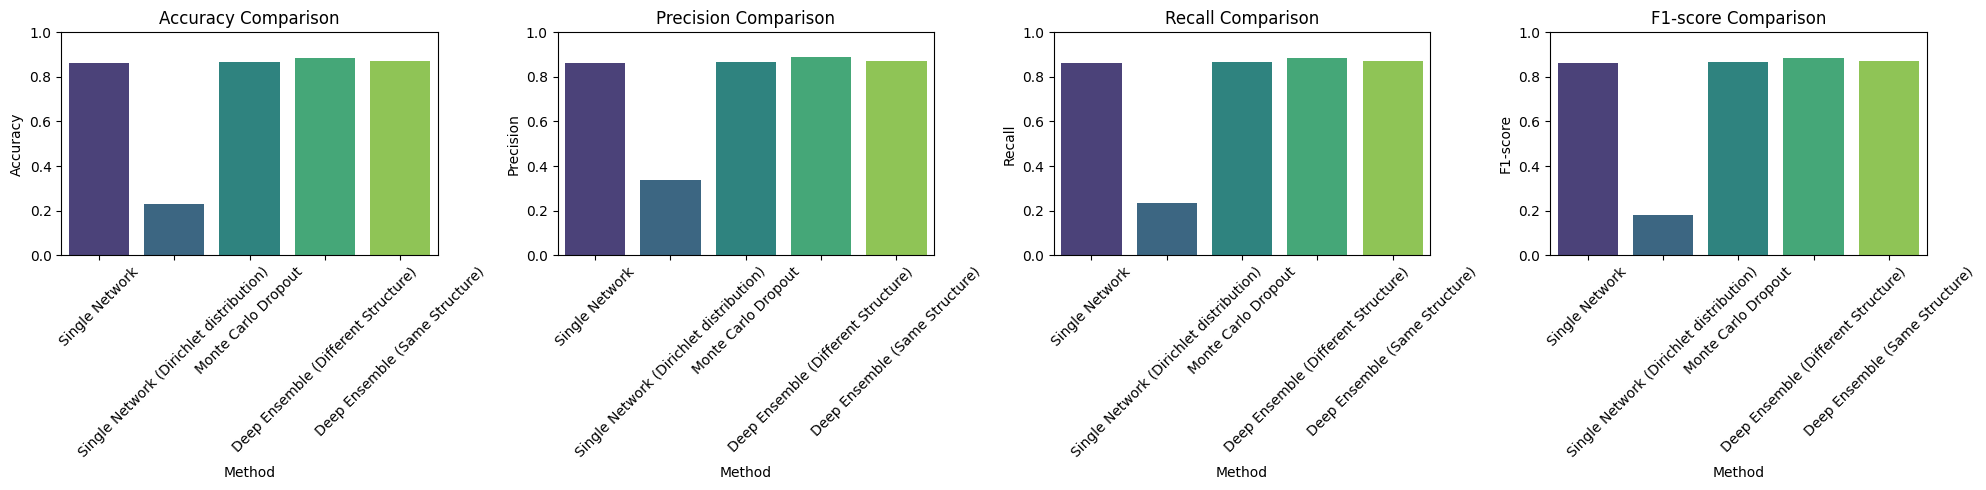

In [152]:
results 
import matplotlib.pyplot as plt

def plot_results(results):
    """Plots a bar chart showing model performance metrics."""
    fig, axes = plt.subplots(1, 4, figsize=(20, 5))

    metrics = ["Accuracy", "Precision", "Recall", "F1-score"]
    for i, metric in enumerate(metrics):
        sns.barplot(x="Method", y=metric, data=results, ax=axes[i], palette="viridis")
        axes[i].set_title(f"{metric} Comparison")
        axes[i].set_ylim(0, 1)
        axes[i].set_ylabel(metric)
        axes[i].set_xticklabels(axes[i].get_xticklabels(), rotation=45)

    plt.tight_layout()
    plt.show()
    
plot_results(df_results)

`3.1 Predictive Entropy (Confidence Histogram)`

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


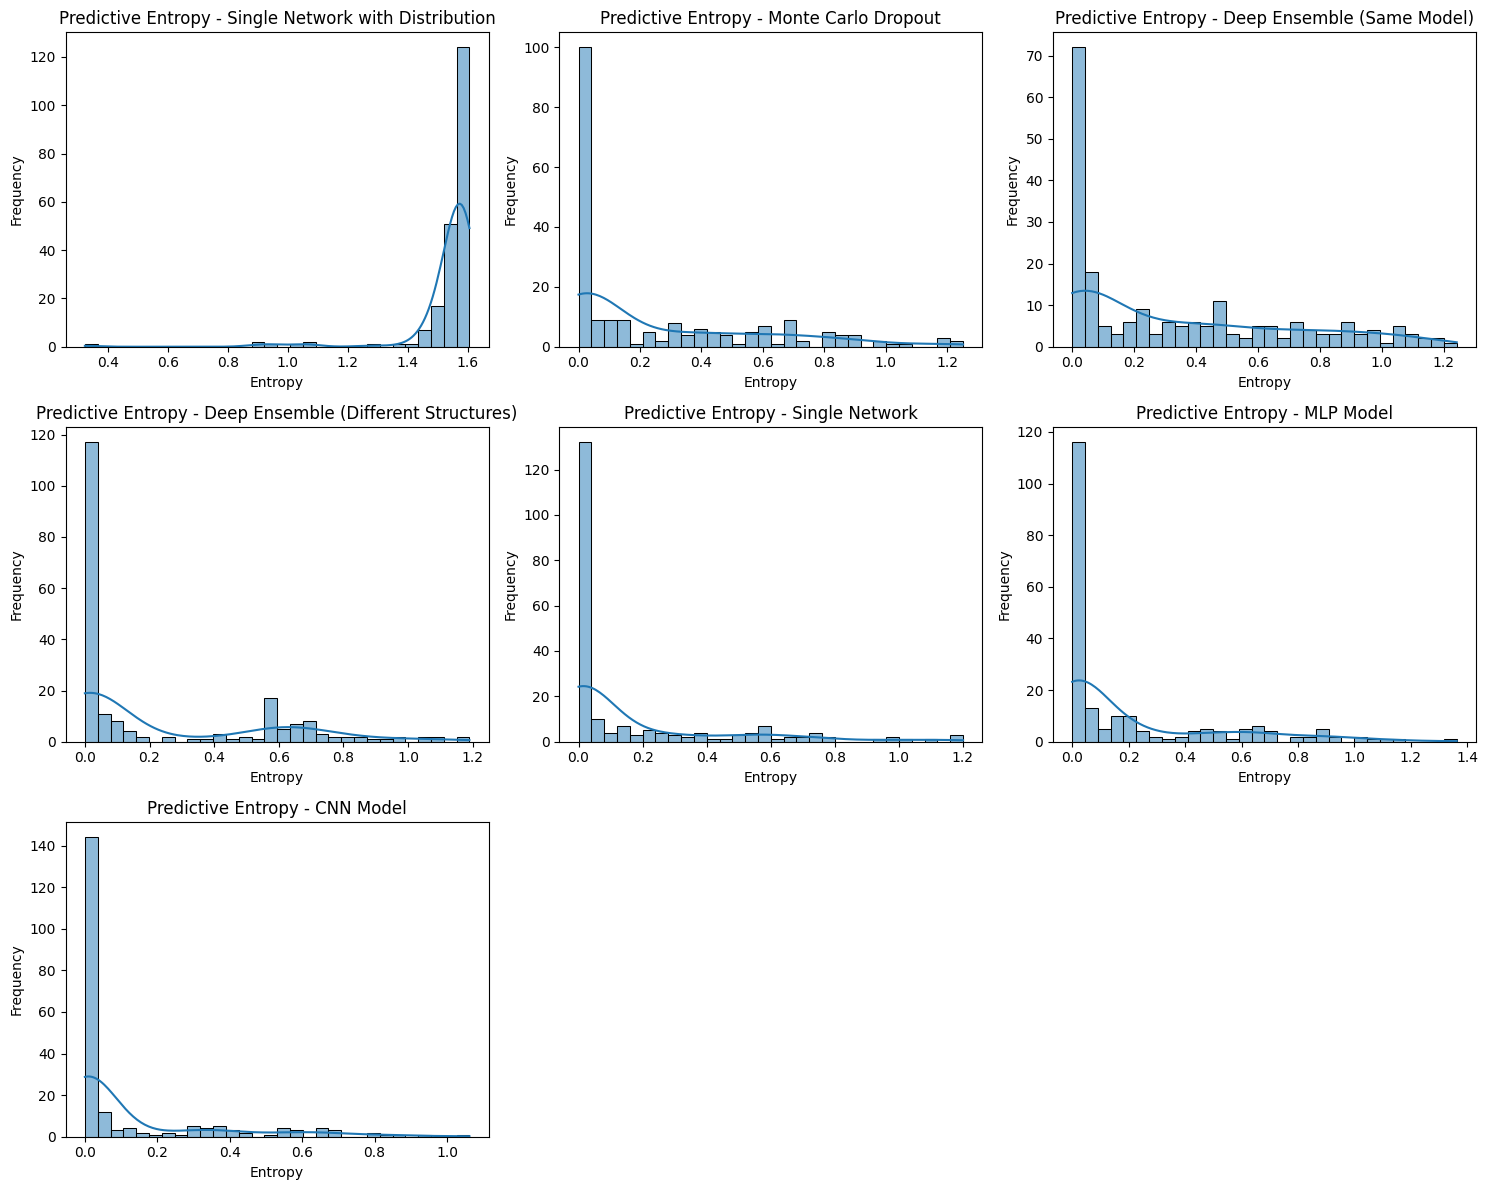

In [129]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def plot_entropy(predictions, title, ax):
    """Plots histogram of predictive entropy for a model."""
    entropy = -np.sum(predictions * np.log(predictions + 1e-8), axis=1)
    sns.histplot(entropy, bins=30, kde=True, ax=ax)
    ax.set_title(f"Predictive Entropy - {title}")
    ax.set_xlabel("Entropy")
    ax.set_ylabel("Frequency")

models = {
    "Single Network with Distribution": dirichlet_model.predict(X_test),
    "Monte Carlo Dropout": mcd_probs,
    "Deep Ensemble (Same Model)": deep_ensemble_prediction(ensemble_models_SS, X_test),
    "Deep Ensemble (Different Structures)": deep_ensemble_prediction(ensemble_models_DS, X_test),
    "Single Network": single_network_model.predict(X_test),
    "MLP Model": mlp_model.predict(X_test),
    "CNN Model": cnn_model.predict(X_test)
}

fig, axes = plt.subplots(3, 3, figsize=(15, 12))

axes = axes.flatten()

for i, (title, preds) in enumerate(models.items()):
    plot_entropy(preds, title, axes[i])

for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


**08. Calibration Analysis (ECE & Brier Score)**

8.1 Expected Calibration Error (ECE)

In [150]:
import numpy as np

def expected_calibration_error(y_true, y_pred_probs, num_bins=15):
    """Computes Expected Calibration Error (ECE) with bin alignment fix."""
    
    if np.any(y_pred_probs < 0) or np.any(y_pred_probs > 1):  
        y_pred_probs = y_pred_probs / np.sum(y_pred_probs, axis=1, keepdims=True)

    bins = np.linspace(0, 1, num_bins + 1) 
    bin_idx = np.digitize(np.max(y_pred_probs, axis=1), bins) - 1 

    bin_idx = np.clip(bin_idx, 0, num_bins - 1) 

    accs = np.array([
        np.mean(y_true[bin_idx == i] == np.argmax(y_pred_probs[bin_idx == i], axis=1)) 
        if np.any(bin_idx == i) else 0.0  
        for i in range(num_bins)
    ])

    confs = np.array([
        np.mean(np.max(y_pred_probs[bin_idx == i], axis=1)) 
        if np.any(bin_idx == i) else 0.0
        for i in range(num_bins)
    ])

    bin_counts = np.bincount(bin_idx, minlength=num_bins)[:num_bins]
    
    ece = np.sum(np.abs(accs - confs) * bin_counts / np.sum(bin_counts))  # ✅ Normalize properly
    return ece


dirichlet_probs = dirichlet_model.predict(X_test)
dirichlet_probs = dirichlet_probs / np.sum(dirichlet_probs, axis=1, keepdims=True)

ece_dirichlet = expected_calibration_error(y_test, dirichlet_probs)
ece_mcd = expected_calibration_error(y_test, mcd_probs)
ece_single_net = expected_calibration_error(y_test, single_network_model.predict(X_test))
ece_ensemble = expected_calibration_error(y_test, deep_ensemble_prediction(ensemble=ensemble_models_DS, X_test=X_test))

print(f"Expected Calibration Error (Dirichlet): {ece_dirichlet:.4f}")
print(f"Expected Calibration Error (Monte Carlo Dropout): {ece_mcd:.4f}")
print(f"Expected Calibration Error (Single Network): {ece_single_net:.4f}")
print(f"Expected Calibration Error (Deep Ensemble): {ece_ensemble:.4f}")


1/7 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
Expected Calibration Error (Dirichlet): 0.0932
Expected Calibration Error (Monte Carlo Dropout): 0.0500
Expected Calibration Error (Single Network): 0.0783
Expected Calibration Error (Deep Ensemble): 0.0508


/tmp/ipykernel_141017/750195857.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ece_values, y=ece_methods, palette="viridis")


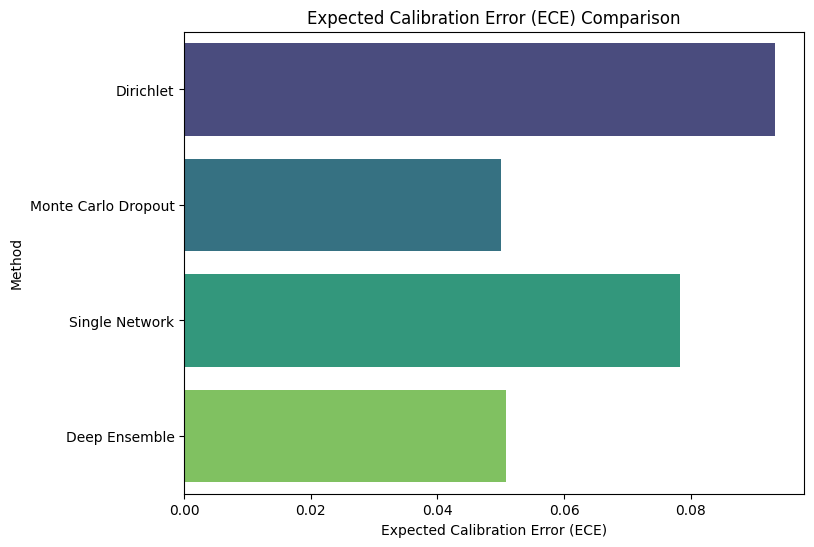

In [ ]:
ece_values = [ece_dirichlet, ece_mcd, ece_single_net, ece_ensemble]
ece_methods = ["Dirichlet", "Monte Carlo Dropout", "Single Network", "Deep Ensemble"]

plt.figure(figsize=(8, 6))
sns.barplot(x=ece_values, y=ece_methods, palette="viridis")
plt.title("Expected Calibration Error (ECE) Comparison")
plt.xlabel("Expected Calibration Error (ECE)")
plt.ylabel("Method")
plt.show()

**Brier score**

In [ ]:
from sklearn.metrics import brier_score_loss
import numpy as np

def compute_brier_score(y_true, y_pred_probs):
    """Computes the Brier Score for a given model."""
    
    num_classes = y_pred_probs.shape[1]
    y_true_one_hot = np.eye(num_classes)[y_true]

    brier_scores = np.mean(np.sum((y_pred_probs - y_true_one_hot) ** 2, axis=1))

    return brier_scores

dirichlet_probs = dirichlet_model.predict(X_test)
dirichlet_probs = dirichlet_probs / np.sum(dirichlet_probs, axis=1, keepdims=True)

brier_dirichlet = compute_brier_score(y_test.astype(int), dirichlet_probs)
brier_mcd = compute_brier_score(y_test.astype(int), mcd_probs)
brier_single = compute_brier_score(y_test.astype(int), single_network_model.predict(X_test))
brier_ensemble = compute_brier_score(y_test.astype(int), deep_ensemble_prediction(ensemble=ensemble_models_DS, X_test=X_test))

print(f"Brier Score (Dirichlet): {brier_dirichlet:.4f}")
print(f"Brier Score (Monte Carlo Dropout): {brier_mcd:.4f}")
print(f"Brier Score (Single Network): {brier_single:.4f}")
print(f"Brier Score (Deep Ensemble): {brier_ensemble:.4f}")


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step 
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
🔹 Brier Score (Dirichlet): 0.8184
🔹 Brier Score (Monte Carlo Dropout): 0.1829
🔹 Brier Score (Single Network): 0.2026
🔹 Brier Score (Deep Ensemble): 0.1623


**VGG_Lite**

After

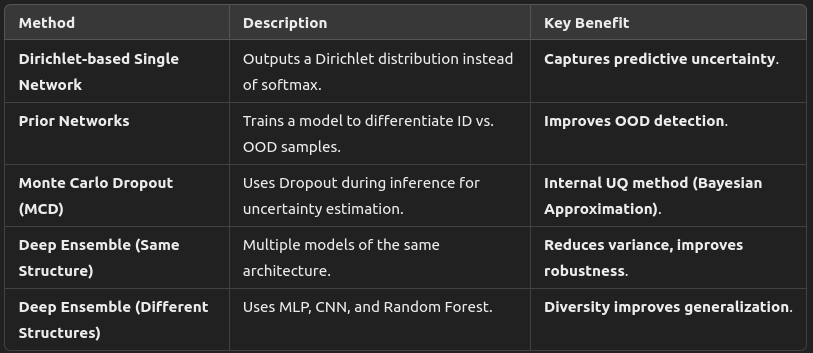

Now that we have trained standard classifiers (SVM, Random Forest), we will apply Uncertainty Quantification (UQ) methods: